In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 11.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import yfinance as yf
from tensorflow import keras
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from sklearn import metrics
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [ ]:
BBNI = yf.download(['BBNI.jk'], 
                      start='2015-01-01', 
                      end='2022-01-01', 
                      progress=False)

In [ ]:
BBNI

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,6050.0,6125.0,6050.0,6100.0,4923.147461,11700700
2015-01-05,6075.0,6075.0,6000.0,6025.0,4862.616211,13824800
2015-01-06,6000.0,6050.0,5950.0,6025.0,4862.616211,23801400
2015-01-07,6000.0,6100.0,5975.0,6075.0,4902.970703,19387800
2015-01-08,6100.0,6125.0,6025.0,6075.0,4902.970703,16755600
...,...,...,...,...,...,...
2021-12-24,6650.0,6725.0,6575.0,6725.0,6603.161621,13733200
2021-12-27,6725.0,6750.0,6675.0,6750.0,6627.708496,10650300
2021-12-28,6750.0,6775.0,6700.0,6700.0,6578.614258,14716300


In [ ]:
BBNI.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1.752000e+03
mean,6569.463470,6649.437785,6483.373288,6565.296804,5967.610550,2.888129e+07
std,1535.396962,1543.080097,1529.993741,1539.965557,1497.799922,2.385012e+07
min,3160.000000,3410.000000,2970.000000,3160.000000,3079.097168,0.000000e+00
25%,5250.000000,5325.000000,5200.000000,5250.000000,4615.783203,1.543820e+07
50%,6512.500000,6600.000000,6425.000000,6500.000000,5847.847412,2.238210e+07
75%,7625.000000,7700.000000,7525.000000,7606.250000,7140.725098,3.486862e+07
max,10175.000000,10250.000000,9900.000000,10175.000000,9137.123047,2.220427e+08


In [ ]:
data=BBNI.filter(['Close'])
dataset=data.values
training_data_len= math.ceil(len(dataset) * .983)

#scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

scaled_data

array([[0.41910192],
       [0.40841055],
       [0.40841055],
       ...,
       [0.50463293],
       [0.50819672],
       [0.51176051]])

In [ ]:
#Create training data set

train_data=scaled_data[0:training_data_len,:]

#split the data into x_train and y_train data sets

x_train =[]
y_train=[]

################### 過去６０日分のデータでYを説明する、という形##################
for i in range(30,len(train_data)):
  x_train.append(train_data[i-30:i,0])
  y_train.append(train_data[i,0])
  if i<=30:

    print(x_train)
    print(y_train)
    print()

[array([0.41910192, 0.40841055, 0.40841055, 0.41553813, 0.41553813,
       0.42622951, 0.41553813, 0.42622951, 0.41910192, 0.42622951,
       0.40128297, 0.40128297, 0.39059159, 0.40128297, 0.39771917,
       0.41910192, 0.41910192, 0.43335709, 0.4297933 , 0.42622951,
       0.44048468, 0.44048468, 0.46543122, 0.47612259, 0.46899501,
       0.50106914, 0.52957947, 0.5188881 , 0.50819672, 0.50819672])]
[0.5010691375623664]



In [ ]:
#convert train data to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)

#Reshape
x_train.shape

(1693, 30)

In [ ]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1693, 30, 1)

In [ ]:
# build LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(1))
#copile the model
model.compile(optimizer='adam',loss='mean_squared_error')
#train the model
model.fit(x_train,y_train,batch_size=32,epochs=50)

Epoch 1/50
53/53 [==============================] - 8s 42ms/step - loss: 0.0398
Epoch 2/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0098
Epoch 3/50
53/53 [==============================] - 4s 79ms/step - loss: 0.0084
Epoch 4/50
53/53 [==============================] - 5s 88ms/step - loss: 0.0090
Epoch 5/50
53/53 [==============================] - 4s 75ms/step - loss: 0.0072
Epoch 6/50
53/53 [==============================] - 5s 88ms/step - loss: 0.0071
Epoch 7/50
53/53 [==============================] - 5s 90ms/step - loss: 0.0063
Epoch 8/50
53/53 [==============================] - 6s 114ms/step - loss: 0.0064
Epoch 9/50
53/53 [==============================] - 5s 91ms/step - loss: 0.0056
Epoch 10/50
53/53 [==============================] - 4s 76ms/step - loss: 0.0056
Epoch 11/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0054
Epoch 12/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0049
Epoch 13/50
53/53 [=================

In [ ]:
#create the testing data set
#create a new array containing scaled values from index 1743 to 2003
test_data=scaled_data[training_data_len - 30:,:]
#create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(30,len(test_data)):
  x_test.append(test_data[i-30:i,0])
  

In [ ]:
#convert the data to a numpy array
x_test=np.array(x_test)
#reshape
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [ ]:
#get the models predicted price values
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)


In [ ]:
#Get the root mean squared error(RMSE)
rmse=np.sqrt( np.mean((predictions - y_test)**2))
rmse

117.94660247372572

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


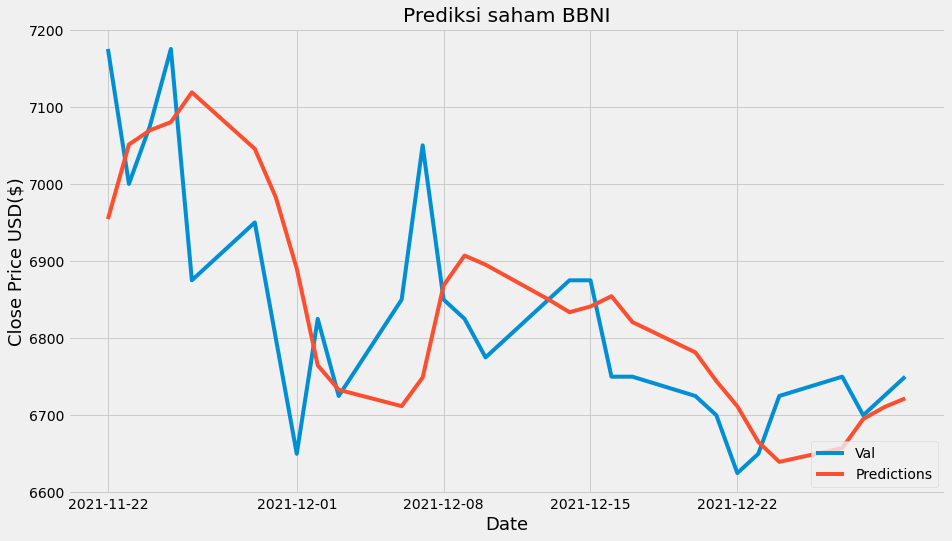

In [ ]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions

#visualize the data
plt.figure(figsize=(14,8))
plt.title('Prediksi saham BBNI')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.plot(valid[['Close','Predictions']])
plt.legend(['Val','Predictions'],loc='lower right')
plt.show()

In [ ]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-11-22,7175.0,6954.414062
2021-11-23,7000.0,7051.074219
2021-11-24,7075.0,7069.499512
2021-11-25,7175.0,7080.099609
2021-11-26,6875.0,7118.722168
2021-11-29,6950.0,7045.462402
2021-11-30,6800.0,6982.701172
2021-12-01,6650.0,6890.192383
2021-12-02,6825.0,6764.753418


In [ ]:
from sklearn.metrics import mean_absolute_error
data[training_data_len:]
predictions
mae = mean_absolute_error(data[training_data_len:], predictions)
print('MAE: %f' % mae)

MAE: 87.638436
